# Differentiable ZNE: Global circuit folding (200 points)

In the "Explorer" level challenge, you looked at modelling noise in a quantum computer. Let's take an adventure into the realm of error-mitigation with the introduction of *global circuit folding*.

Error mitigation is the idea that we can bypass, or mitigate, errors that are present in real quantum hardware without actually doing anything to the hardware itself. Remember those bitflip errors you looked at? What if there was a way to get rid of them without actually getting rid of them?

How can we do this in practice? With zero-noise extrapolation (ZNE)!

The ZNE protocol approaches error mitigation in a somewhat backwards way; instead of coming up with a way to reduce the error directly, we *instead* increase the error and extrapolate *bac*k to zero error. In other words, we want to create more noise in order to extrapolate less noise. So how do we create more noise?

One way to create more noise in a quantum circuit being run on real hardware is to increase the depth of the quantum circuit. Imagine I have some unitary $U$ that describes my quantum circuit. I still want my circuit to effectively be described by $U$, but what's to stop us from doing this: $U\rightarrow U\mathbb{I}^{n}=U(U^{+}U)^{n}$? At the end of the day, the circuit is still doing the same thing, but we've increased the number of gates in the circuit $d$ to be $d\rightarrow d(2n+1)$. If programming each gate onto a real device imparts some noise, we've introduced more noise from this mapping!

We can generalize the mapping $U\rightarrow U(U^{+}U)^{n}$ further by including partial folds:

$U\rightarrow U(U^{+}U)^{n}\rightarrow U(U^{+}U)^{n}L_{d}^{+}...L_{s}^{+}L_{s}...L_{d}$

where $s\in \left [ 1,d \right ]$ and $L_{i}$ denotes a quantum gate within $U$. Specifically, $U=L_{1}L_{2}...L_{s}...L_{d}$. In this challenge, you will implement a noisy circuit $U(U^{+}U)^{n}L_{d}^{+}...L_{s}^{+}L_{s}...L_{d}$.

### Challenge code

The provided code below contains several functions:

- `U`: A quantum function that applies the gates in the circuit (i.e. all of the $L_{i}$'s):

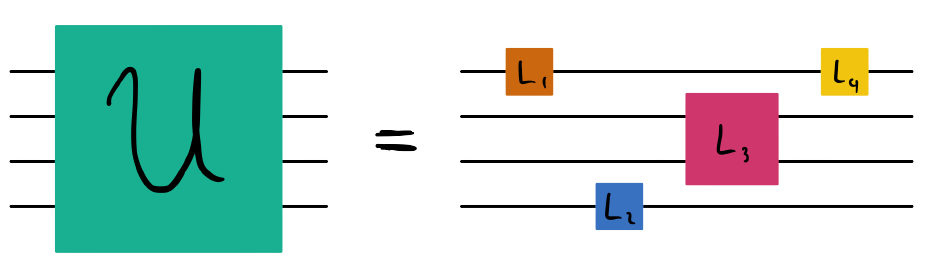

- `circuit`: A noisy circuit using , where noise is placed on every gate (see dev_noisy). Here, the noise is described by a depolarizing channel.
- `circuit_ops`: A function that returns all of the gates in `circuit`.
- `global_fold_circuit`: A noisy circuit that implements the global circuit folding protocol: $U(U^{+}U)^{n}L_{d}^{+}...L_{s}^{+}L_{s}...L_{d}$. **You must complete this function**.
- `fidelity`: A function that calculates the fidelity between the output state from `circuit` (i.e. the original circuit) and the state from `global_fold_circuit`. Your `global_fold_circuit` function's validity will be assessed via the `fidelity` function.

#### Input
As input to this problem, you will be given:

- `angle`: a rotation angle needed to define `U`
- `n`: the number of times $U^{+}U$ gets implemented
- `s`: the parameter that defines $L_{s}...L_{d}$
Please note that `s` will be given as an integer $\left [ 1,d \right ]$. Make sure to index properly!
#### Output

This code will output the fidelity, a float, between the output state from circuit and the state from `global_fold_circuit`.

If your solution matches the correct one within the given tolerance specified in `check` (in this case it's a `1e-4` relative error tolerance), the output will be `"Correct!"`. Otherwise, you will receive a `"Wrong answer"` prompt.

Good luck!

In [1]:
import functools
import json
import math
import pandas as pd
import pennylane as qml
import pennylane.numpy as np
import scipy

In [2]:
dev_ideal = qml.device("default.mixed", wires=2)  # no noise
dev_noisy = qml.transforms.insert(qml.DepolarizingChannel, 0.05, position="all")(
    dev_ideal
)

def U(angle):
    """A quantum function containing one parameterized gate.

    Args:
        angle (float): The phase angle for an IsingXY operator
    """
    qml.Hadamard(0)
    qml.Hadamard(1)
    qml.CNOT(wires=[0, 1])
    qml.PauliZ(1)
    qml.IsingXY(angle, [0, 1])
    qml.S(1)

@qml.qnode(dev_noisy)
def circuit(angle):
    """A quantum circuit made from the quantum function U.

    Args:
        angle (float): The phase angle for an IsingXY operator

    Returns:
        (numpy.array): A quantum state.
    """
    U(angle)
    return qml.state()

@qml.tape.stop_recording()
def circuit_ops(angle):
    """A function that outputs the operations within the quantum function U.

    Args:
        angle (float): The phase angle for an IsingXY operator

    Returns:
        (list(qml.operation.Operation)): A list of operations that make up the unitary U.
    """
    with qml.tape.QuantumTape() as tape:
        U(angle)
    return tape.operations

In [3]:
@qml.qnode(dev_noisy)
def global_fold_circuit(angle, n, s):
    """Performs the global circuit folding procedure.

    Args:
        angle (float): The phase angle for an IsingXY operator
        n: The number of times U^\dagger U is applied
        s: The integer defining L_s ... L_d.

    Returns:
        (numpy.array): A quantum state.
    """
    assert s <= len(
        circuit_ops(angle)
    ), "The value of s is upper-bounded by the number of gates in the circuit."

    U(angle)  # Original circuit application


    # Put your code here #
   # Put your code here #
    d = len(circuit_ops(angle))
    print("d is: " + str(d))
    for i in range(n):
        qml.adjoint(U)(angle)
        U(angle)
        
    # L_d^\dagger ... L_s^\dagger

    for i in range(d-1, s-2, -1):
        qml.adjoint(circuit_ops(angle)[i])

    # L_s ... L_d
    for i in range(s-1, d):
        qml.apply(circuit_ops(angle)[i])
        
    return qml.state()

In [4]:
def fidelity(angle, n, s):
    fid = qml.math.fidelity(global_fold_circuit(angle, n, s), circuit(angle))
    return np.round_(fid, decimals=5)

In [5]:
# These functions are responsible for testing the solution.

def run(test_case_input: str) -> str:
    angle, n, s = json.loads(test_case_input)
    fid = fidelity(angle, n, s)
    return str(fid)

def check(solution_output: str, expected_output: str) -> None:
    solution_output = json.loads(solution_output)
    expected_output = json.loads(expected_output)
    assert np.allclose(
        solution_output, expected_output, rtol=1e-4
    ), "Your folded circuit isn't quite right!"

In [6]:
test_cases = [['[0.4, 2, 3]', '0.79209']]

In [7]:
for i, (input_, expected_output) in enumerate(test_cases):
    print(f"Running test case {i} with input '{input_}'...")

    try:
        output = run(input_)

    except Exception as exc:
        print(f"Runtime Error. {exc}")

    else:
        if message := check(output, expected_output):
            print(f"Wrong Answer. Have: '{output}'. Want: '{expected_output}'.")

        else:
            print("Correct!")

Running test case 0 with input '[0.4, 2, 3]'...
d is: 6
Correct!
